In [1]:
import glob
import pandas as pd
import wandb
import itertools
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.cm import coolwarm
from matplotlib.colors import Normalize

In [2]:
def find_pkl_file(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.pkl'):
                return os.path.join(root, file)
    return None

In [3]:
# run_path = "alexhg/Branin budget data set/27japxej"
# api = wandb.Api()
# eps = 1e-3
# run = api.run(run_path)
# logdir = "/network/scratch/n/nikita.saxena/logs/activelearning/2023-04-30_23-53-51"
# 42 Train Points
logdir = "/network/scratch/n/nikita.saxena/logs/activelearning/2023-05-06_19-03-57"

In [4]:
culm_pkl_file = find_pkl_file(logdir)
culm_pkl = pd.read_pickle(culm_pkl_file)
culm_samples = culm_pkl['cumulative_sampled_samples']
culm_energies = culm_pkl['cumulative_sampled_energies']
culm_states = np.array(culm_pkl['cumulative_sampled_states'])
culm_fidelities = culm_pkl['cumulative_sampled_fidelities'].detach().cpu().numpy()
culm_states_naked = culm_states[:, :-1]

In [5]:
def readable2state(readable, alphabet={}):
    """
    Converts a human-readable string representing a state into a state as a list of
    positions.
    """
    return [int(el) for el in readable.strip("[]").split(" ") if el != ""]

In [6]:
initial_dataset = pd.read_csv("/home/mila/n/nikita.saxena/activelearning/storage/branin/mf/data_train.csv")
train_samples = initial_dataset['samples']
train_samples_naked = []
fid_train_samples = []
for sample in train_samples:
    # print(sample.split(';')[0])
    fid_train_samples.append(int(sample.split(';')[1]))
    sample = sample.split(';')[0]
    train_samples_naked.append(readable2state(sample))
# print(train_samples_naked)
train_samples_naked = np.array(train_samples_naked).astype(np.float32)

In [7]:
# print(culm_states[0:10])
# print(culm_fidelities[0:10])
# print(culm_states_naked[0:10])

In [46]:
length = 10
grid_size = length * length
rescale = 15
culm_states_naked = culm_states_naked / (grid_size - 1)
culm_states_naked[:, 0] = culm_states_naked[:, 0] * rescale - 5
culm_states_naked[:, 1] = culm_states_naked[:, 1] * rescale

train_samples_naked = train_samples_naked / (grid_size - 1)
train_samples_naked[:, 0] = train_samples_naked[:, 0] * rescale - 5
train_samples_naked[:, 1] = train_samples_naked[:, 1] * rescale

grid_scores = np.zeros((length, length))

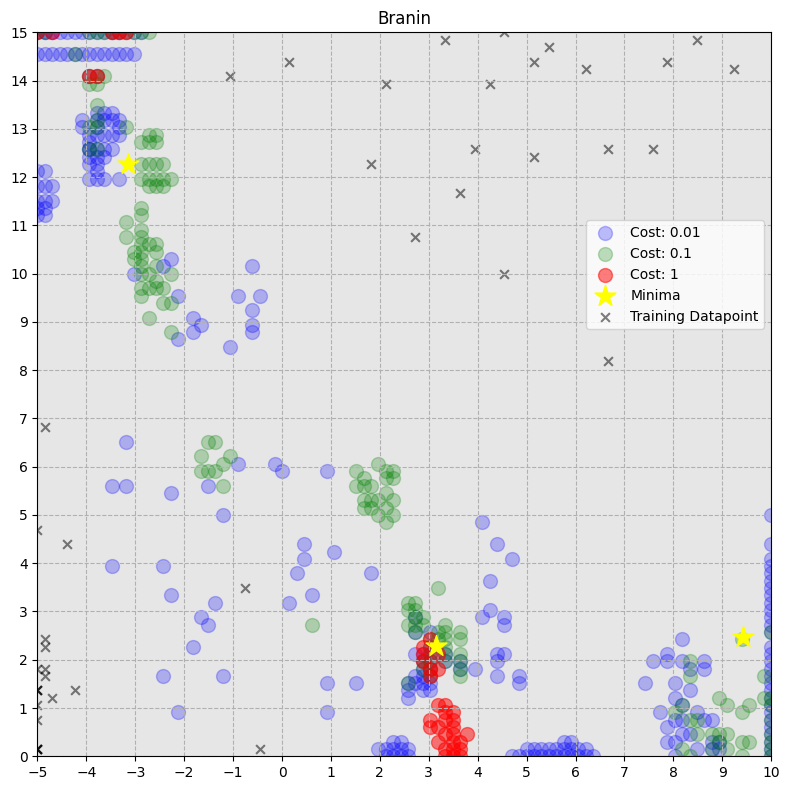

In [58]:
fig, ax = plt.subplots(1,1, figsize=(8, 8))
fid_color = {0: 'b', 1: 'g', 2: 'r'}
label = ['Cost: 0.01', 'Cost: 0.1', 'Cost: 1']
train_fid_color = {0: 'darkblue', 1: 'g', 2: 'r'}
alpha = {0: 0.25, 1: 0.25, 2: 0.5}
ax.set_ylim(bottom=0, top=15)
ax.set_xlim(-5, 10)
ax.set_xticks(
            np.arange(start=-5, stop=11, step=1)
        )
ax.set_yticks(
            np.arange(start=0, stop=16, step=1)
        )
for i in range(3):
    idx = np.where(culm_fidelities == i)[0]
    states_for_idx = culm_states_naked[idx]
    color = fid_color[i]
    ax.scatter(states_for_idx[:, 0], states_for_idx[:, 1], color=color, s=100, alpha=alpha[i], label = label[i])
    train_for_idx = train_samples_naked[np.where(np.array(fid_train_samples) == i)[0]]
    # ax.scatter(train_for_idx[:, 0], train_for_idx[:, 1], color=color, s=100, marker="x", alpha=1)

modes = np.array([[-3.14, 12.275], [3.14, 2.275], [9.424, 2.475]])
ax.scatter(modes[:, 0], modes[:, 1], color='yellow', s=250, marker="*", label='Minima')
ax.scatter(train_samples_naked[:, 0], train_samples_naked[:, 1], color='black', s=40, marker="x", alpha=0.5, label='Training Datapoint')
ax.legend(loc='upper right', bbox_to_anchor=(1.0, 0.75))
ax.set_title('Branin')
# Adjust the spacing between subplots
plt.tight_layout()
# ax.legend()
ax.grid(True, linestyle='--')
# set background color
ax.set_facecolor('#E6E6E6')
# Show the plot
plt.show()